# **XAI dla zbioru danych Adult**

## Fetching Data

### Import Package and Data

In [201]:
!pip install shap
!pip install ucimlrepo

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import shap

shap.initjs()
%matplotlib inline

In [204]:
income_df = pd.read_csv("/content/drive/MyDrive/Xaiun/adult.csv")
income_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [205]:
income_df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## Data Cleaning

 ### Dealing with Missing Value

In [206]:
income_df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Attributes workclass, occupation, and native-country most NAs. Let's drop these NA.

In [207]:
income_df.age = income_df.age.astype(float)
income_df['hours-per-week'] = income_df['hours-per-week'].astype(float)

In [208]:
my_df = income_df.dropna()

In [209]:
my_df['predclass'] = my_df['income']
del my_df['income']
my_df['education-num'] = my_df['educational-num']
del my_df['educational-num']


In [210]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  float64
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  int64  
 3   education       48842 non-null  object 
 4   marital-status  48842 non-null  object 
 5   occupation      48842 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   gender          48842 non-null  object 
 9   capital-gain    48842 non-null  int64  
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  48842 non-null  float64
 12  native-country  48842 non-null  object 
 13  predclass       48842 non-null  object 
 14  education-num   48842 non-null  int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 5.6+ MB


In [211]:
my_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
predclass         0
education-num     0
dtype: int64

## Feature Engineering

In [212]:
print('workclass',my_df.workclass.unique())
print('education',my_df.education.unique())
print('marital-status',my_df['marital-status'].unique())
print('occupation',my_df.occupation.unique())
print('relationship',my_df.relationship.unique())
print('race',my_df.race.unique())
print('gender',my_df.gender.unique())
print('native-country',my_df['native-country'].unique())
print('predclass',my_df.predclass.unique())

workclass ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']
relationship ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
gender ['Male' 'Female']
native-country ['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 

### Education

In [213]:
#income_df[['education', 'education-num']].groupby(['education'], as_index=False).mean().sort_values(by='education-num', ascending=False)

In [214]:

my_df['education'].replace('Preschool', 'dropout',inplace=True)
my_df['education'].replace('10th', 'dropout',inplace=True)
my_df['education'].replace('11th', 'dropout',inplace=True)
my_df['education'].replace('12th', 'dropout',inplace=True)
my_df['education'].replace('1st-4th', 'dropout',inplace=True)
my_df['education'].replace('5th-6th', 'dropout',inplace=True)
my_df['education'].replace('7th-8th', 'dropout',inplace=True)
my_df['education'].replace('9th', 'dropout',inplace=True)
my_df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
my_df['education'].replace('HS-grad', 'HighGrad',inplace=True)
my_df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
my_df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
my_df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
my_df['education'].replace('Bachelors', 'Bachelors',inplace=True)
my_df['education'].replace('Masters', 'Masters',inplace=True)
my_df['education'].replace('Prof-school', 'Masters',inplace=True)
my_df['education'].replace('Doctorate', 'Doctorate',inplace=True)

In [215]:
my_df[['education', 'education-num']].groupby(['education'], as_index=False).mean().sort_values(by='education-num', ascending=False)

,education,education-num
2,Doctorate,16.000000
4,Masters,14.238900
0,Bachelors,13.000000
1,CommunityCollege,10.361967
3,HighGrad,9.000000
5,dropout,5.614544


<ipython-input-216-72c53feb210f>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='education'>

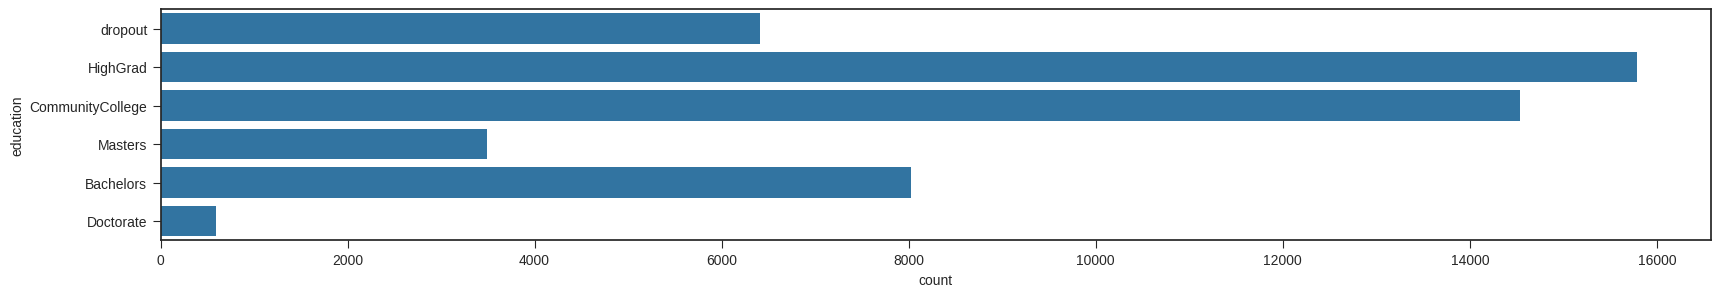

In [216]:
fig = plt.figure(figsize=(20,3))
plt.style.use('seaborn-ticks')
sns.countplot(y="education", data=my_df)

### Marital-status

In [217]:
#df2 = my_df['marital-status'].replace(' Never-married', 'NotMarried')
my_df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
my_df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
my_df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
my_df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
my_df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
my_df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
my_df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

<ipython-input-218-268f72a2957a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='marital-status'>

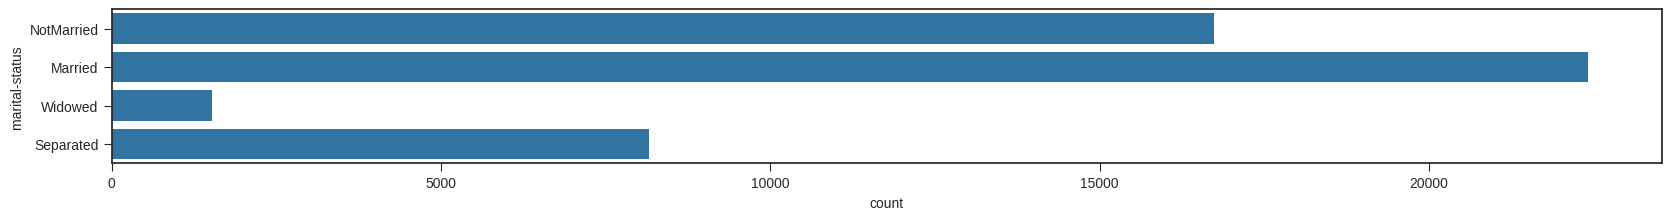

In [218]:
fig = plt.figure(figsize=(20,2))
plt.style.use('seaborn-ticks')
sns.countplot(y="marital-status", data=my_df)

### Occupation

<ipython-input-219-9ce7077d62f4>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='occupation'>

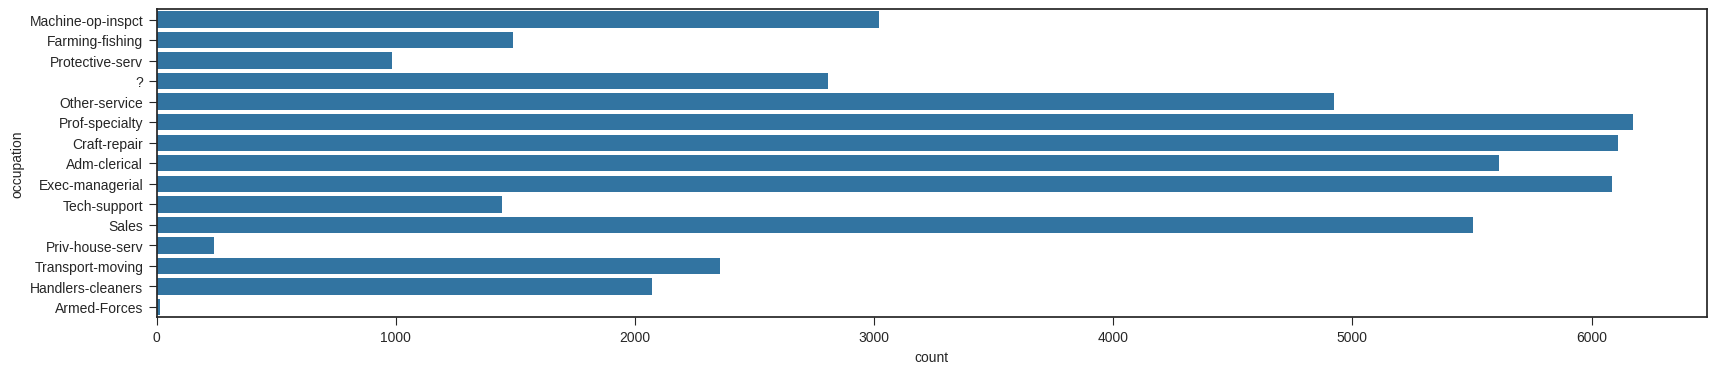

In [219]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(20,4))
sns.countplot(y="occupation", data=my_df)

### Workclass

<ipython-input-220-0f7e63378bcb>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='workclass'>

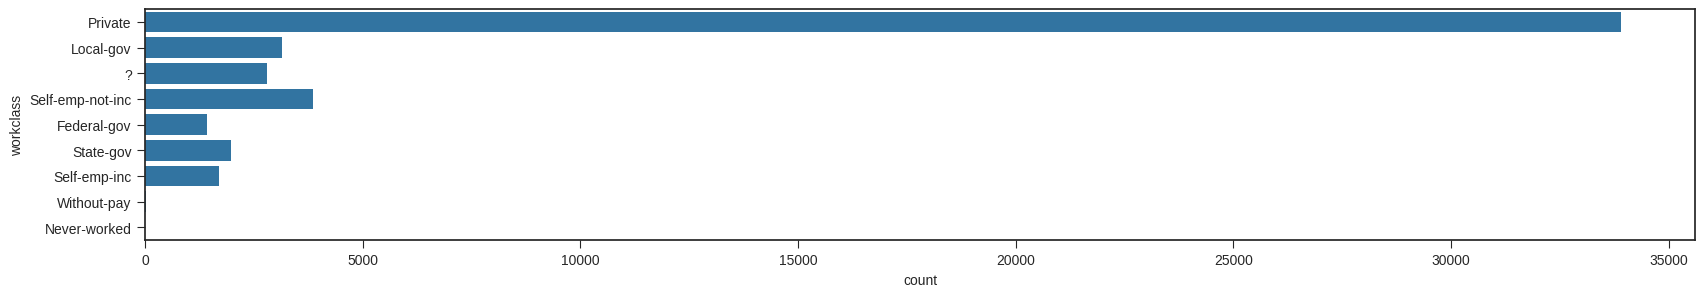

In [220]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(20,3))
sns.countplot(y="workclass", data=my_df)

In [221]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
#grid = sns.FacetGrid(my_df, col='predclass', row='workclass', size=2.2, aspect=1.6)
#grid.map(plt.hist, 'age', alpha=.5, bins=20)
#grid.add_legend()

### age

In [222]:
# make the age variable discretized
my_df['age_bin'] = pd.cut(my_df['age'], 20)

<ipython-input-223-bce54a08a96a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')
<ipython-input-223-bce54a08a96a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(my_df[my_df['predclass'] == '>50K']['age'], kde_kws={"label": ">$50K"})
<ipython-input-223-bce54a08a96a>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your cod

<Axes: xlabel='age', ylabel='Density'>

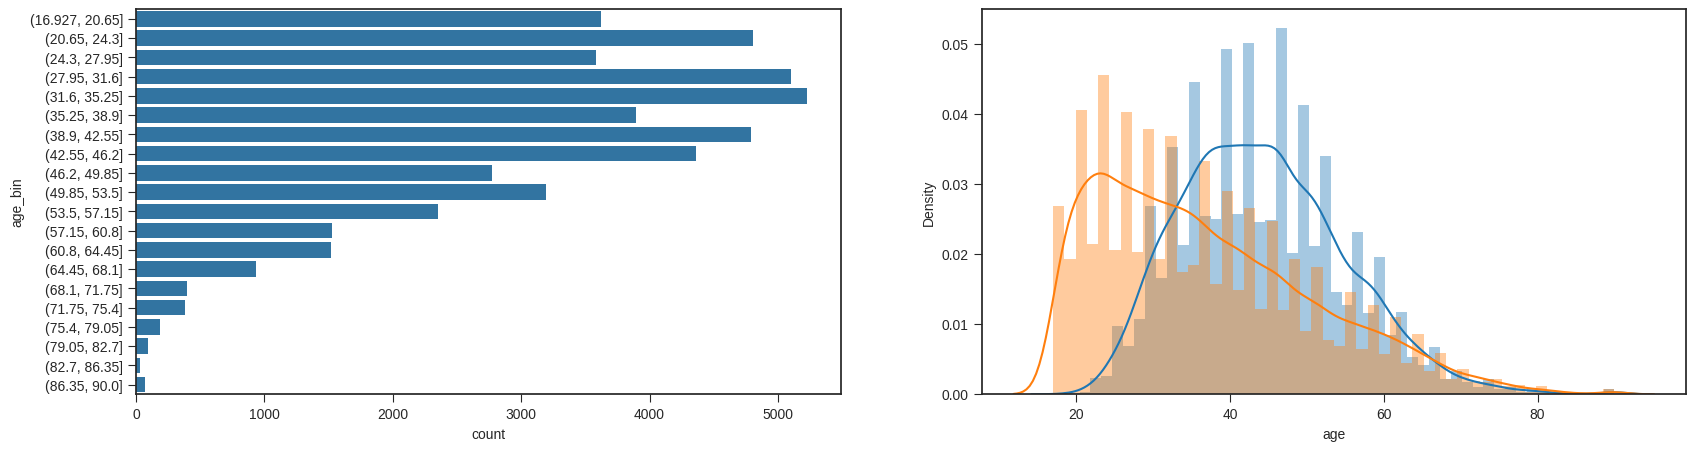

In [223]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.countplot(y="age_bin", data=my_df)
plt.subplot(1, 2, 2)
sns.distplot(my_df[my_df['predclass'] == '>50K']['age'], kde_kws={"label": ">$50K"})
sns.distplot(my_df[my_df['predclass'] == '<=50K']['age'], kde_kws={"label": "<=$50K"})

In [224]:
my_df[['predclass', 'age']].groupby(['predclass'], as_index=False).mean().sort_values(by='age', ascending=False)

,predclass,age
1,>50K,44.275178
0,<=50K,36.872184


### Race

<ipython-input-225-0d8ab2e2f495>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Axes: xlabel='race', ylabel='prop'>

<Figure size 2000x500 with 0 Axes>

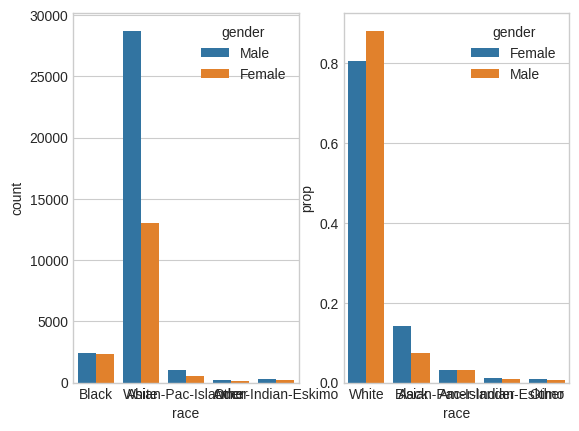

In [225]:
plt.style.use('seaborn-whitegrid')
x, y, hue = "race", "prop", "gender"
#hue_order = ["Male", "Female"]
plt.figure(figsize=(20,5))
f, axes = plt.subplots(1, 2)
sns.countplot(x=x, hue=hue, data=my_df, ax=axes[0])

prop_df = (my_df[x]
           .groupby(my_df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])


### Hours of Work

In [226]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
my_df['hours-per-week_bin'] = pd.cut(my_df['hours-per-week'], 10)
my_df['hours-per-week'] = my_df['hours-per-week']

### Create a crossing feature: Age + hour of work

In [227]:
#g = sns.jointplot(x = 'age',
#              y = 'hours-per-week',
#              data = my_df,
#              kind = 'hex',
#              cmap= 'hot',
#              size=10)

#http://stackoverflow.com/questions/33288830/how-to-plot-regression-line-on-hexbins-with-seaborn
#sns.regplot(my_df.age, my_df['hours-per-week'], ax=g.ax_joint, scatter=False, color='grey')

In [228]:
my_df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,predclass,education-num,age_bin,hours-per-week_bin
0,25.0,Private,226802,dropout,NotMarried,Machine-op-inspct,Own-child,Black,Male,0,0,40.0,United-States,<=50K,7,"(24.3, 27.95]","(30.4, 40.2]"
1,38.0,Private,89814,HighGrad,Married,Farming-fishing,Husband,White,Male,0,0,50.0,United-States,<=50K,9,"(35.25, 38.9]","(40.2, 50.0]"
2,28.0,Local-gov,336951,CommunityCollege,Married,Protective-serv,Husband,White,Male,0,0,40.0,United-States,>50K,12,"(27.95, 31.6]","(30.4, 40.2]"
3,44.0,Private,160323,CommunityCollege,Married,Machine-op-inspct,Husband,Black,Male,7688,0,40.0,United-States,>50K,10,"(42.55, 46.2]","(30.4, 40.2]"
4,18.0,?,103497,CommunityCollege,NotMarried,?,Own-child,White,Female,0,0,30.0,United-States,<=50K,10,"(16.927, 20.65]","(20.6, 30.4]"


In [229]:
# Crossing Numerical Features
my_df['age-hours'] = my_df['age']*my_df['hours-per-week']
my_df['age-hours_bin'] = pd.cut(my_df['age-hours'], 10)

<ipython-input-230-5e5680a1e417>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-230-5e5680a1e417>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(my_df[my_df['predclass'] == '>50K']['age-hours'], kde_kws={"label": ">$50K"})
<ipython-input-230-5e5680a1e417>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adap

<Axes: xlabel='age-hours', ylabel='Density'>

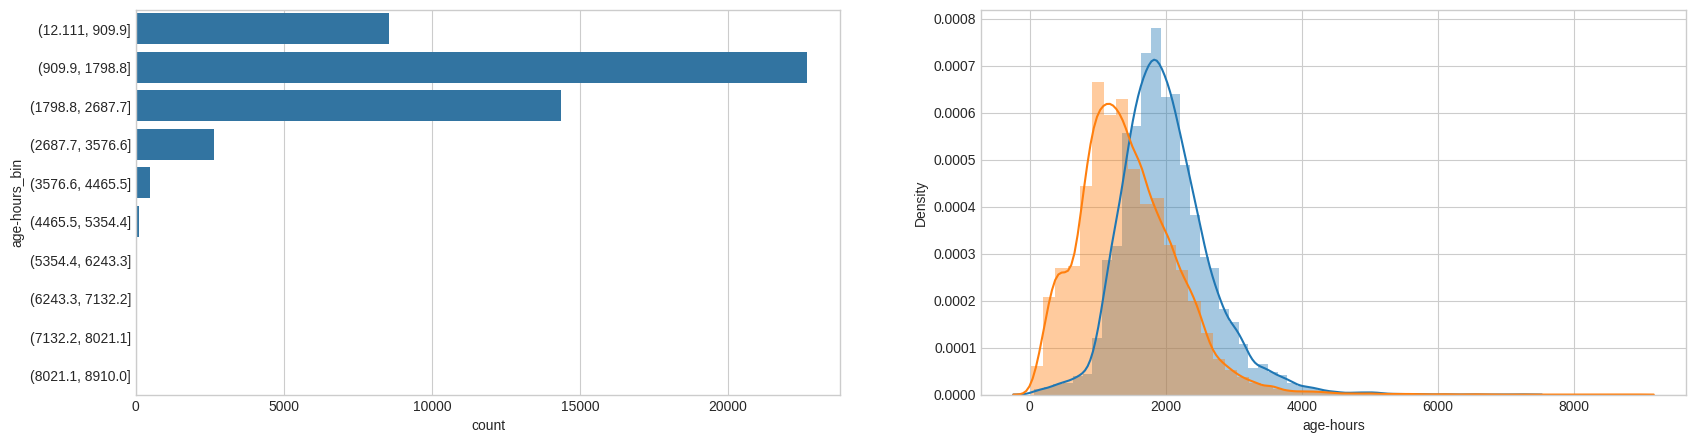

In [230]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours_bin", data=my_df);
plt.subplot(1, 2, 2)
sns.distplot(my_df[my_df['predclass'] == '>50K']['age-hours'], kde_kws={"label": ">$50K"})
sns.distplot(my_df[my_df['predclass'] == '<=50K']['age-hours'], kde_kws={"label": "<$50K"})

The dataset was created in 1996, a large number of jobs fall into the category of mannual labor, e.g., Handlers cleaners, craft repairers, etc. Executive managerial role and some one with a professional speciality has a high level payment.

![censusrace](https://user-images.githubusercontent.com/31974451/36568899-8e25bc6c-17e0-11e8-9e85-53d0f5cc1d7f.png)


## Building Machine Learning Models

In [231]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import GridSearchCV


#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
#train,test=train_test_split(train_df,test_size=0.2,random_state=0,stratify=abalone_data['Sex'])

### Feature Encoding

In [232]:
# Feature Selection and Encoding
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split #training and testing data split


In [233]:
my_df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,predclass,education-num,age_bin,hours-per-week_bin,age-hours,age-hours_bin
0,25.0,Private,226802,dropout,NotMarried,Machine-op-inspct,Own-child,Black,Male,0,0,40.0,United-States,<=50K,7,"(24.3, 27.95]","(30.4, 40.2]",1000.0,"(909.9, 1798.8]"
1,38.0,Private,89814,HighGrad,Married,Farming-fishing,Husband,White,Male,0,0,50.0,United-States,<=50K,9,"(35.25, 38.9]","(40.2, 50.0]",1900.0,"(1798.8, 2687.7]"
2,28.0,Local-gov,336951,CommunityCollege,Married,Protective-serv,Husband,White,Male,0,0,40.0,United-States,>50K,12,"(27.95, 31.6]","(30.4, 40.2]",1120.0,"(909.9, 1798.8]"
3,44.0,Private,160323,CommunityCollege,Married,Machine-op-inspct,Husband,Black,Male,7688,0,40.0,United-States,>50K,10,"(42.55, 46.2]","(30.4, 40.2]",1760.0,"(909.9, 1798.8]"
4,18.0,?,103497,CommunityCollege,NotMarried,?,Own-child,White,Female,0,0,30.0,United-States,<=50K,10,"(16.927, 20.65]","(20.6, 30.4]",540.0,"(12.111, 909.9]"


In [234]:
my_df = my_df.apply(LabelEncoder().fit_transform)
my_df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,predclass,education-num,age_bin,hours-per-week_bin,age-hours,age-hours_bin
0,8,4,19329,5,1,7,3,2,1,0,0,39,39,0,6,2,3,478,1
1,21,4,4212,3,0,5,0,4,1,0,0,49,39,0,8,5,4,818,2
2,11,2,25340,1,0,11,0,4,1,0,0,39,39,1,11,3,3,530,1
3,27,4,11201,1,0,7,0,2,1,98,0,39,39,1,9,7,3,766,1
4,1,0,5411,1,1,0,3,4,0,0,0,29,39,0,9,0,2,285,0


### Train-test split

In [235]:
drop_elements = ['education', 'native-country', 'predclass', 'age_bin', 'age-hours_bin','hours-per-week_bin']
y = my_df["predclass"]
X = my_df.drop(drop_elements, axis=1)
X.head()

,age,workclass,fnlwgt,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,education-num,age-hours
0,8,4,19329,1,7,3,2,1,0,0,39,6,478
1,21,4,4212,0,5,0,4,1,0,0,49,8,818
2,11,2,25340,0,11,0,4,1,0,0,39,11,530
3,27,4,11201,0,7,0,2,1,98,0,39,9,766
4,1,0,5411,1,0,3,4,0,0,0,29,9,285


In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [237]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_1, X_resampled_2, y_resampled_1, y_resampled_2 = train_test_split(X_resampled, y_resampled, test_size=0.5, stratify= y_resampled)

smote2 = SMOTE()

X_resampled_test, y_resampled_test = smote2.fit_resample(X_test, y_test)

#### Random Forest

In [238]:
# Random Forest Classifier
randomforest1 = RandomForestClassifier(n_estimators = 10)
randomforest1.fit(X_resampled_1, y_resampled_1)

randomforest2 = RandomForestClassifier(n_estimators = 10)
randomforest2.fit(X_resampled_2, y_resampled_2)
y_pred = randomforest2.predict(X_test)
print(y_pred)
score_randomforest1 = randomforest1.score(X_resampled_test,y_resampled_test)
score_randomforest2 = randomforest2.score(X_resampled_test,y_resampled_test)

print('The accuracy of the Random Forest Model 1 is', score_randomforest1)
print('The accuracy of the Random Forest Model 2 is', score_randomforest2)

[0 1 0 ... 0 0 1]
The accuracy of the Random Forest Model 1 is 0.8504816697886005
The accuracy of the Random Forest Model 2 is 0.8522879314958522


In [239]:
print(X_resampled_1)

       age  workclass  fnlwgt  marital-status  occupation  relationship  race  \
4582    25          1    2144               0          10             0     4   
8484     2          0   21936               1           0             4     4   
7739    28          4   13573               2           3             1     4   
35057   10          4   27160               1           6             1     2   
42744   48          0   11740               0           0             0     4   
...    ...        ...     ...             ...         ...           ...   ...   
38053   30          4   16903               2          12             1     4   
22389   34          7   10701               0          12             0     4   
26345   24          7    2095               2          10             3     4   
30268   30          6   13542               0          10             0     4   
29224   38          0    8828               0           0             0     4   

       gender  capital-gain

#### Counting SHAP values

In [240]:
explainer1 = shap.TreeExplainer(randomforest1)
explainer2 = shap.TreeExplainer(randomforest2)

shap_values_cat_rfr1 = explainer1.shap_values(X_resampled_test)
shap_values_cat_rfr2 = explainer2.shap_values(X_resampled_test)

print(np.shape(shap_values_cat_rfr1))
print(np.shape(shap_values_cat_rfr2))

(14948, 13, 2)
(14948, 13, 2)


In [242]:
# Decission plot dla wartości 0
shap.decision_plot(explainer_xgb1.expected_value[0], shap_values_cat_xgb1[0], X_resampled_test.columns)
shap.decision_plot(explainer_xgb2.expected_value[0], shap_values_cat_xgb2[0], X_resampled_test.columns)

IndexError: invalid index to scalar variable.

### XGBoost

In [260]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier(objective="binary:logistic")
xgb1.fit(X_resampled_1, y_resampled_1)

xgb2 = xgb.XGBClassifier(objective="binary:logistic")
xgb2.fit(X_resampled_2, y_resampled_2)
y_pred = xgb1.predict(X_test)
score_xgb1 = xgb1.score(X_resampled_test,y_resampled_test)
score_xgb2 = xgb2.score(X_resampled_test,y_resampled_test)

print('The accuracy of the XGB Model 1 is', score_xgb1)
print('The accuracy of the XGB Model 2 is', score_xgb2)

The accuracy of the XGB Model 1 is 0.8841985549906342
The accuracy of the XGB Model 2 is 0.87998394434038


In [261]:
y_pred = xgb1.predict(X_resampled_1)
print(y_pred)
y_pred = xgb2.predict(X_resampled_2)
print(y_pred)

[1 0 0 ... 0 1 0]
[1 0 1 ... 0 0 1]


In [245]:
explainer_xgb1 = shap.Explainer(xgb1)
explainer_xgb2 = shap.Explainer(xgb2)

shap_values_cat_xgb1 = explainer_xgb1.shap_values(X_resampled_test)
shap_values_cat_xgb2 = explainer_xgb2.shap_values(X_resampled_test)

exp_values_cat_xgb1 = explainer_xgb1(X_resampled_test)
exp_values_cat_xgb2 = explainer_xgb2(X_resampled_test)

print(np.shape(shap_values_cat_xgb1))
print(np.shape(shap_values_cat_xgb2))

(14948, 13)
(14948, 13)


In [246]:
print(y_resampled[0])
print(y_resampled[2])

0
1


In [247]:
#np.save('/content/drive/MyDrive/Xaiun/shap_rfr1.npy', shap_values_cat_rfr1)

In [248]:
#np.save('/content/drive/MyDrive/Xaiun/shap_rfr2.npy', shap_values_cat_rfr1)
#np.save('/content/drive/MyDrive/Xaiun/shap_xgb1.npy', shap_values_cat_xgb1)
#np.save('/content/drive/MyDrive/Xaiun/shap_xgb2.npy', shap_values_cat_xgb2)

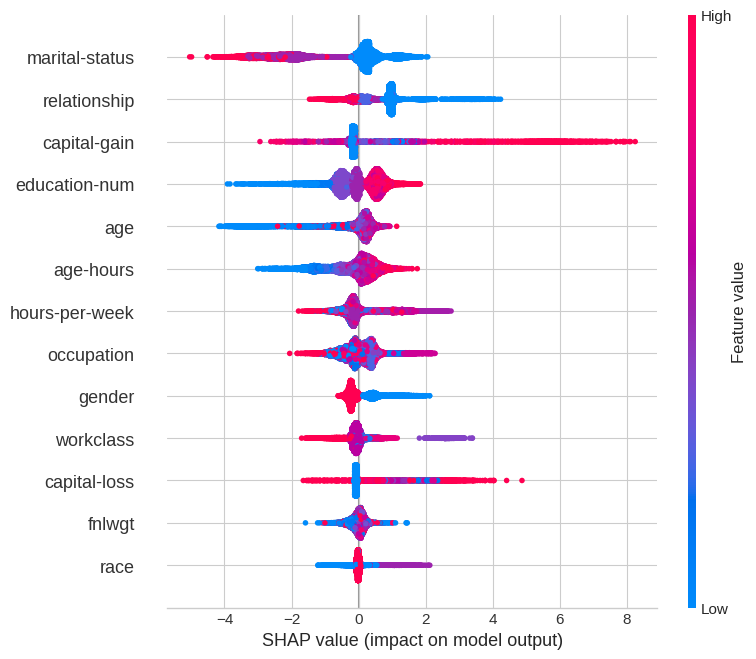

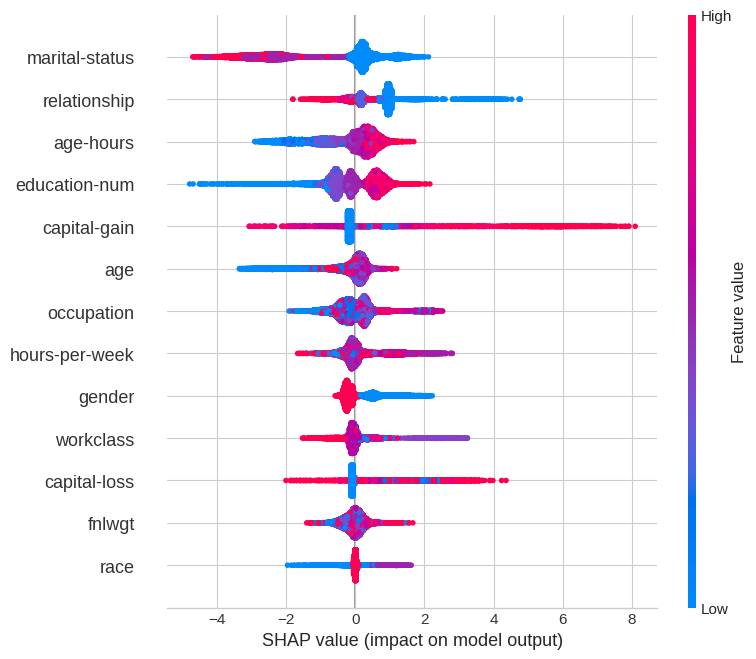

In [249]:
#Summary plot
shap.summary_plot(shap_values_cat_xgb1, X_resampled_test)
shap.summary_plot(shap_values_cat_xgb2, X_resampled_test)

In [250]:
# Force plot dla wartości 0
#print(np.shape(shap_values_cat_xgb1[0, :])
#print(explainer_xgb1.expected_value[0])
#print(np.shape(shap_values_cat_xgb1[0, :]))
#shap.plots.force(explainer_xgb1.expected_value[0], shap_values_cat_xgb1[0, :], X_resampled_test.iloc[0, :], matplotlib = True)
#shap.plots.force(explainer_xgb2.expected_value[0], shap_values_cat_xgb2[0, :], X_resampled_test.iloc[0, :], matplotlib = True)

In [251]:
# Force plot dla wartości 1
#shap.plots.force(explainer_xgb1.expected_value[0], shap_values_cat_xgb1[0][0,:], X_resampled_test.iloc[0, :], matplotlib = True)
#shap.plots.force(explainer_xgb2.expected_value[0], shap_values_cat_xgb2[0][0,:], X_resampled_test.iloc[0, :], matplotlib = True)

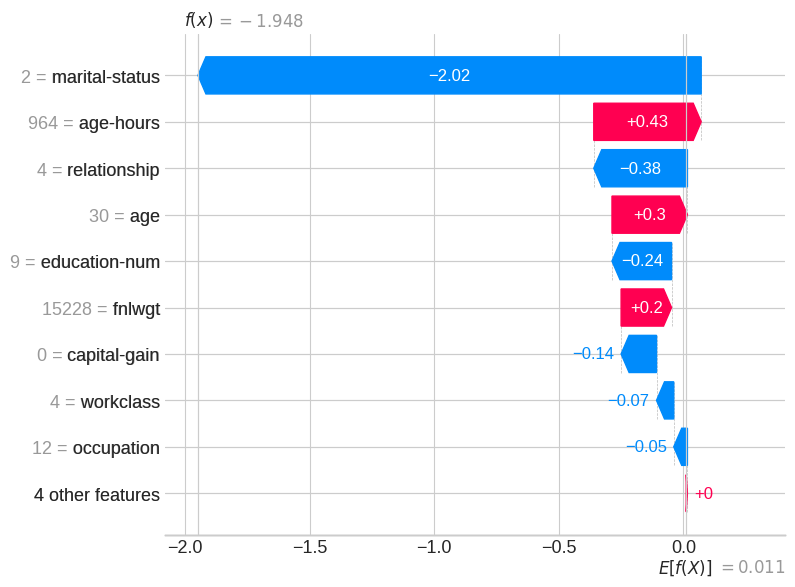

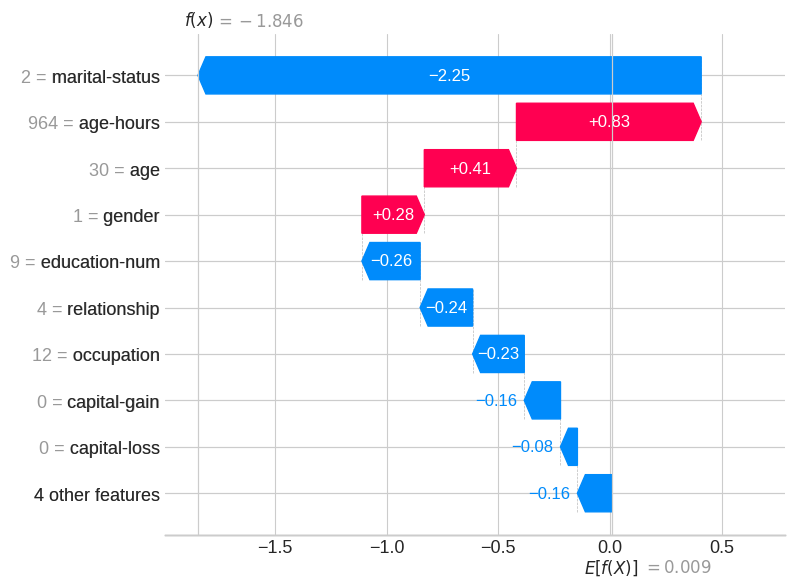

In [252]:
# Wykres waterfall dla obiektu klasy 0
shap.plots.waterfall(exp_values_cat_xgb1[0])
shap.plots.waterfall(exp_values_cat_xgb2[0])

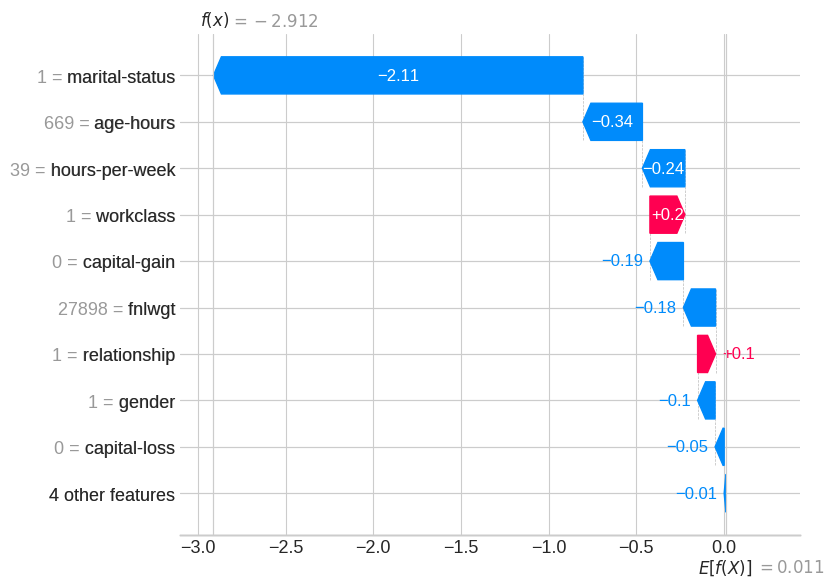

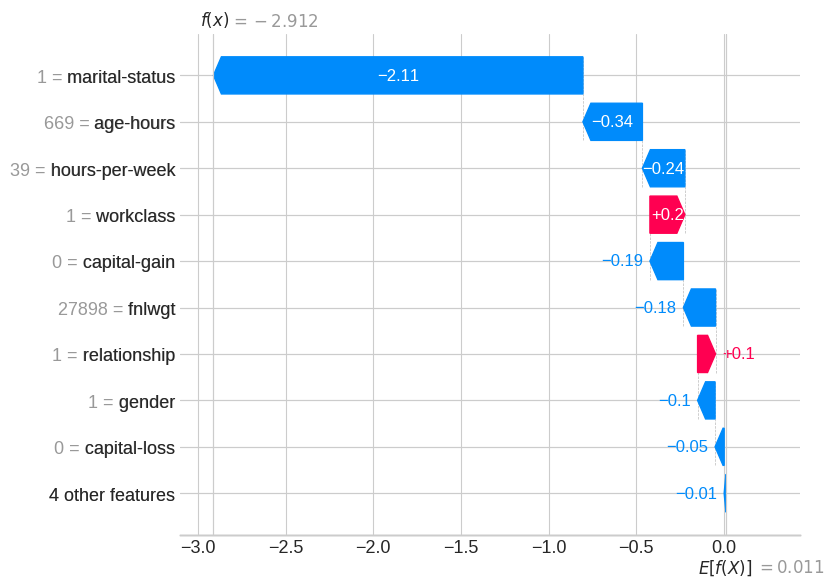

In [253]:
# Wykres waterfall dla obiektu klasy 1
shap.plots.waterfall(exp_values_cat_xgb1[2])
shap.plots.waterfall(exp_values_cat_xgb1[2])

In [254]:
# Wykres force dla obiektu klasy 0
shap.initjs()
shap.plots.force(exp_values_cat_xgb1[0], link="logit")

In [255]:
# Wykres force dla obiektu klasy 0
shap.initjs()
shap.plots.force(exp_values_cat_xgb2[0], link="logit")

In [256]:
# Wykres force dla obiektu klasy 1
shap.initjs()
shap.plots.force(exp_values_cat_xgb1[2], link="logit")

In [257]:
# Wykres force dla obiektu klasy 1
shap.initjs()
shap.plots.force(exp_values_cat_xgb2[2], link="logit")

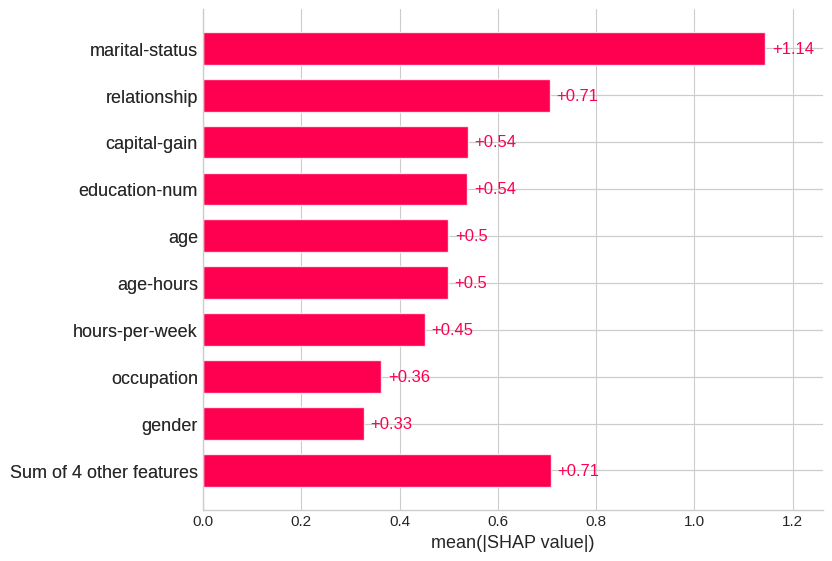

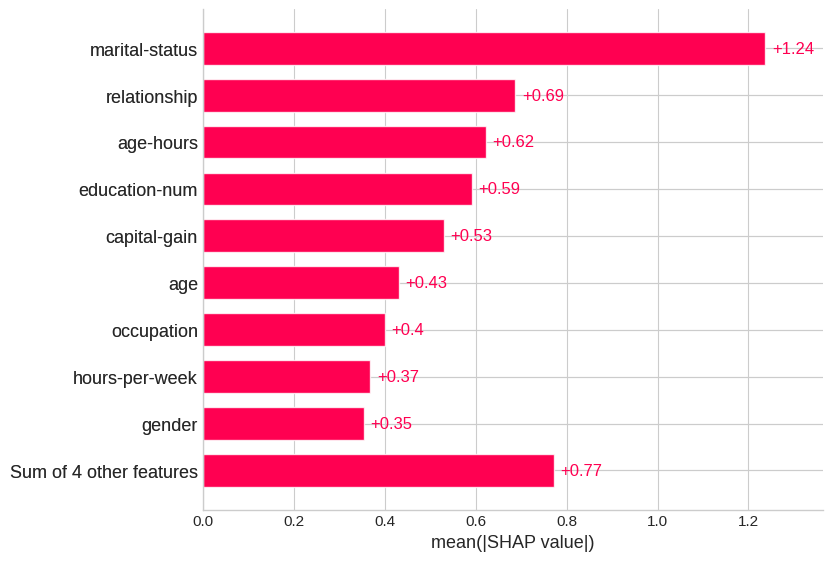

In [258]:
shap.plots.bar(exp_values_cat_xgb1)
shap.plots.bar(exp_values_cat_xgb2)

In [259]:
i = 2
print(y_resampled)
print(xgb1.predict(X_resampled))
print(xgb2.predict(X_resampled))

0        0
1        0
2        1
3        0
4        0
        ..
59357    1
59358    1
59359    1
59360    1
59361    1
Name: predclass, Length: 59362, dtype: int64
[0 0 1 ... 1 1 1]
[0 0 1 ... 1 1 1]
